In [1]:
import torch
from model_protein_moe import trans_basic_block, trans_basic_block_Config
from utils_search import *
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict
import faiss


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
#Protein-Vec MOE model checkpoint and config
vec_model_cpnt = 'protein_vec_models/protein_vec.ckpt'
vec_model_config = 'protein_vec_models/protein_vec_params.json'

In [3]:
#Load the ProtTrans model and ProtTrans tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

model = model.to(device)
model = model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
#Load the model
vec_model_config = trans_basic_block_Config.from_json(vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(vec_model_cpnt, config=vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint protein_vec_models/protein_vec.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.8.0rc0 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint protein_vec_models/tm_vec_swiss_model_large.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint protein_vec_models/aspect_vec_pfam.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint protein_vec_models/aspect_vec_gene3D.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to

In [5]:
# Load in uniprot meta data
meta_data_new = pd.read_csv('data/uniprotkb_AND_reviewed_true_2023_07_03.tsv', sep='\t')

In [7]:
#Now filter for the proteins that were newly discovered
new_proteins = meta_data_new[meta_data_new['Date of creation'] > '2022-05-25'].reset_index(drop=True)

In [8]:
print('Number of new proteins deposited after 2022-05-25')
len(new_proteins)

Number of new proteins deposited after 2022-05-25


2350

In [ ]:
# This is a forward pass of the Protein-Vec model
# Every aspect is turned on (therefore no masks)
sampled_keys = np.array(['TM', 'PFAM', 'GENE3D', 'ENZYME', 'MFO', 'BPO', 'CCO'])
all_cols = np.array(['TM', 'PFAM', 'GENE3D', 'ENZYME', 'MFO', 'BPO', 'CCO'])
masks = [all_cols[k] in sampled_keys for k in range(len(all_cols))]
masks = torch.logical_not(torch.tensor(masks, dtype=torch.bool))[None,:]

#Pull out sequences for the new proteins
flat_seqs = new_proteins['Sequence'].values

#Loop through the sequences and embed them using protein-vec
i = 0
embed_all_sequences = []
while i < len(flat_seqs): 
    protrans_sequence = featurize_prottrans(flat_seqs[i:i+1], model, tokenizer, device)
    embedded_sequence = embed_vec(protrans_sequence, model_deep, masks, device)
    embed_all_sequences.append(embedded_sequence)
    i = i + 1
    if i % 50 == 0:
        print(i)    


In [16]:
#Combine the embedding vectors into an array
query_embeddings = np.concatenate(embed_all_sequences)

Now that we have embeddings for the newly discovered proteins, we can visualize them after performing TSNE, and we can transfer annotations to them as well

In [21]:
#Perform TSNE on the embedding vectors
all_X_embedded = TSNE(n_components=2, perplexity=10, learning_rate='auto', init='random').fit_transform(query_embeddings)
all_X_embedded_df = pd.DataFrame(all_X_embedded)
all_X_embedded_df.columns = ["Dim1", "Dim2"]
all_X_embedded_df['Pfam'] = new_proteins['Pfam'].values[:len(all_X_embedded_df)]
all_X_embedded_df['EC'] = new_proteins['EC number'].values[:len(all_X_embedded_df)]

/opt/anaconda3/envs/langchain/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


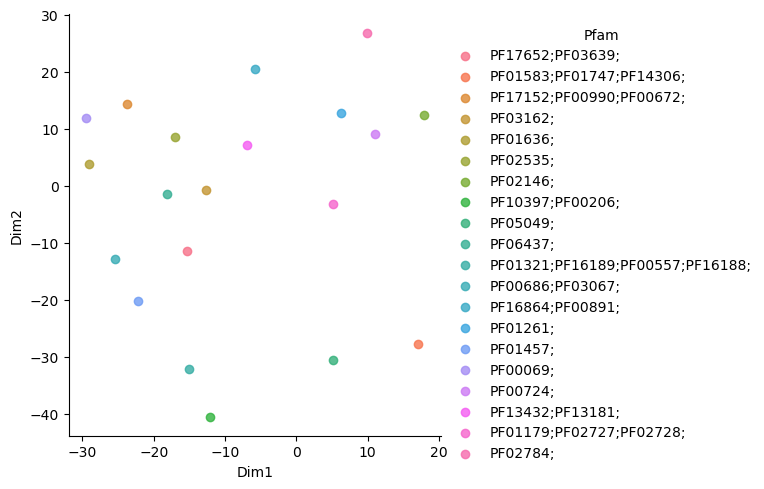

In [22]:
#For visualization purposes, filter for the top 20 PFam terms
top_ranks = list(all_X_embedded_df['Pfam'].value_counts()[0:20].index)
sns.lmplot(x="Dim1", y="Dim2", data=all_X_embedded_df[all_X_embedded_df['Pfam'].isin(top_ranks)], hue="Pfam", fit_reg=False)


In [23]:
################## Load the lookup database of all embeddings (note that we will pull out only embeddings from proteins that were trained on)
embeddings = np.load('protein_vec_embeddings/lookup_embeddings.npy')
lookup_proteins_meta = pd.read_csv('protein_vec_embeddings/lookup_embeddings_meta_data.tsv', sep="\t")


In [24]:
print("Maximum date of lookup database protein")
np.max(lookup_proteins_meta['Date of creation'])

Maximum date of lookup database protein


'2022-05-25'

We can run search and the nearest neighbor pipeline for any of our available aspects
 - 'Gene Ontology (biological process)'
 - 'Gene Ontology (molecular function)' 
 - 'Gene Ontology (cellular component)' 
 - 'Gene3D' 
 - 'Pfam' 
 - 'EC number'

In [25]:
#Switch this for whichever aspect you want to perform search for
############### User parameter
column = 'Pfam'

In [26]:
# Filter for lookup proteins with annotations for the relavant aspect (don't want to transfer null annotations)
col_lookup = lookup_proteins_meta[~lookup_proteins_meta[column].isnull()]
col_lookup_embeddings = embeddings[col_lookup.index]
col_meta_data = col_lookup[column].values

# load database
lookup_database = load_database(col_lookup_embeddings)

# Query for the 1st nearest neighbor
k = 1
D, I = query(lookup_database, query_embeddings, k)

#Get metadata for the 1st nearest neighbor
near_ids = []
for i in range(I.shape[0]):
    meta = col_meta_data[I[i]]
    near_ids.append(list(meta))       

near_ids = np.array(near_ids)

In [27]:
print("Annotations for the nearest neighbors (with aspect annotations) of newly discovered proteins")
print(near_ids)

Annotations for the nearest neighbors (with aspect annotations) of newly discovered proteins
[['PF10645;PF17652;PF03639;']
 ['PF01583;PF01747;PF14306;']
 ['PF01370;']
 ['PF08417;PF00355;']
 ['PF08516;PF00200;PF01562;PF01421;']
 ['PF03038;']
 ['PF03171;PF14226;']
 ['PF00125;PF16211;PF01661;']
 ['PF00198;PF00364;PF02817;']
 ['PF17152;PF00990;']
 ['PF03162;']
 ['PF01636;']
 ['PF02535;']
 ['PF02146;']
 ['PF10397;PF00206;']
 ['PF03787;']
 ['PF05049;']
 ['PF06437;']
 ['PF01321;PF16189;PF00557;PF16188;']
 ['PF18416;PF03067;']
 ['PF00891;']
 ['PF01261;']
 ['PF01457;']
 ['PF13947;PF07714;PF14380;']
 ['PF00724;']
 ['PF13432;PF13181;']
 ['PF01307;']
 ['PF01179;PF02727;PF02728;']
 ['PF02784;']
 ['PF02784;PF00278;']]
